### About this file
The data we have is from 90,189 players that installed the game while the AB-test was running.
When a player installed the game, he or she was randomly assigned to either.

### Column descriptions
* **userid** - A unique number that identifies each player.
* **version** - Whether the player was put in the control group (gate30 - a gate at level 30) or the group with the moved gate (gate40 - a gate at level 40).
* **sum_gamerounds** - The number of game rounds played by he player during the first 14 days after install.
* **retention_1** - Did the player come back and play 1 day after installing?
* **retention_7** - Did the player come back and play 7 days after installing?

#### Задание
*Проанализируйте результаты эксперимента и напишите свои рекомендации менеджеру.*
Можно выделить три метрики:
* метрику timespentperday  , по количеству раундов относительно 14 дней(длина эксперимента)
* retention day 1
* retention day 7


In [1]:
import numpy as np
import pandas as pd


import scipy.stats as sts
import statsmodels.stats.power as smp
import statsmodels.stats.proportion as props
import statsmodels.api as sm
from matplotlib import pyplot as plt


In [2]:
data = pd.read_csv('.\результаты А_B - cookie_cats 2.csv') 
data.head(10)

,userid,version,sum_gamerounds,retention_1,retention_7
0,116,gate_30,3,0,0
1,337,gate_30,38,1,0
2,377,gate_40,165,1,0
3,483,gate_40,1,0,0
4,488,gate_40,179,1,1
5,540,gate_40,187,1,1
6,1066,gate_30,0,0,0
7,1444,gate_40,2,0,0
8,1574,gate_40,108,1,1
9,1587,gate_40,153,1,0


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90189 entries, 0 to 90188
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   userid          90189 non-null  int64 
 1   version         90189 non-null  object
 2   sum_gamerounds  90189 non-null  int64 
 3   retention_1     90189 non-null  int64 
 4   retention_7     90189 non-null  int64 
dtypes: int64(4), object(1)
memory usage: 3.4+ MB


Пустых строк нет

In [4]:
var_doubles = data.\
    groupby('userid', as_index=False).\
    agg({'version': pd.Series.nunique})

In [5]:
var_doubles.head(10)

,userid,version
0,116,1
1,337,1
2,377,1
3,483,1
4,488,1
5,540,1
6,1066,1
7,1444,1
8,1574,1
9,1587,1


In [6]:
more_than_one_types = var_doubles.query('version > 1')
more_than_one_types

,userid,version


In [7]:
data_clean = data[~data['userid'].isin(more_than_one_types.userid)].sort_values('userid')

In [8]:
data_clean.head(10)

,userid,version,sum_gamerounds,retention_1,retention_7
0,116,gate_30,3,0,0
1,337,gate_30,38,1,0
2,377,gate_40,165,1,0
3,483,gate_40,1,0,0
4,488,gate_40,179,1,1
5,540,gate_40,187,1,1
6,1066,gate_30,0,0,0
7,1444,gate_40,2,0,0
8,1574,gate_40,108,1,1
9,1587,gate_40,153,1,0


In [9]:
data.shape

(90189, 5)

Проверили по **user_id** , сплитование тоже корректно, так как не было ни одного пользователя, попавшего в оба варианта теста.

In [10]:
group30 = data_clean[data["version"] == "gate_30"]
len(group30)

44700

In [11]:
group40 = data_clean[data["version"] == "gate_40"]
len(group40)

45489

In [12]:
len(group30)/len(group40)

0.9826551473982721

Выборки считаем приблизительно равными(разница по числу пользователей меньше 5%)

*Посмотрим первую метрику по списку:*
#### количество раундов , сыгранных пользователями .

In [13]:
group30.sum_gamerounds.describe()

count    44700.000000
mean        52.456264
std        256.716423
min          0.000000
25%          5.000000
50%         17.000000
75%         50.000000
max      49854.000000
Name: sum_gamerounds, dtype: float64

Отфильтруем выбросы по квантилям

In [14]:

rounds30 = group30[(group30.sum_gamerounds >= group30.sum_gamerounds.quantile(0.25)) & (group30.sum_gamerounds <= group30.sum_gamerounds.quantile(0.75))].sum_gamerounds.values
rounds30

array([38, 39, 14, ..., 21, 10, 28], dtype=int64)

In [15]:
rounds40 = group40[(group40.sum_gamerounds >= group40.sum_gamerounds.quantile(0.25)) & (group40.sum_gamerounds <= group40.sum_gamerounds.quantile(0.75))].sum_gamerounds.values
rounds40

array([30,  9, 45, ..., 30, 51, 16], dtype=int64)

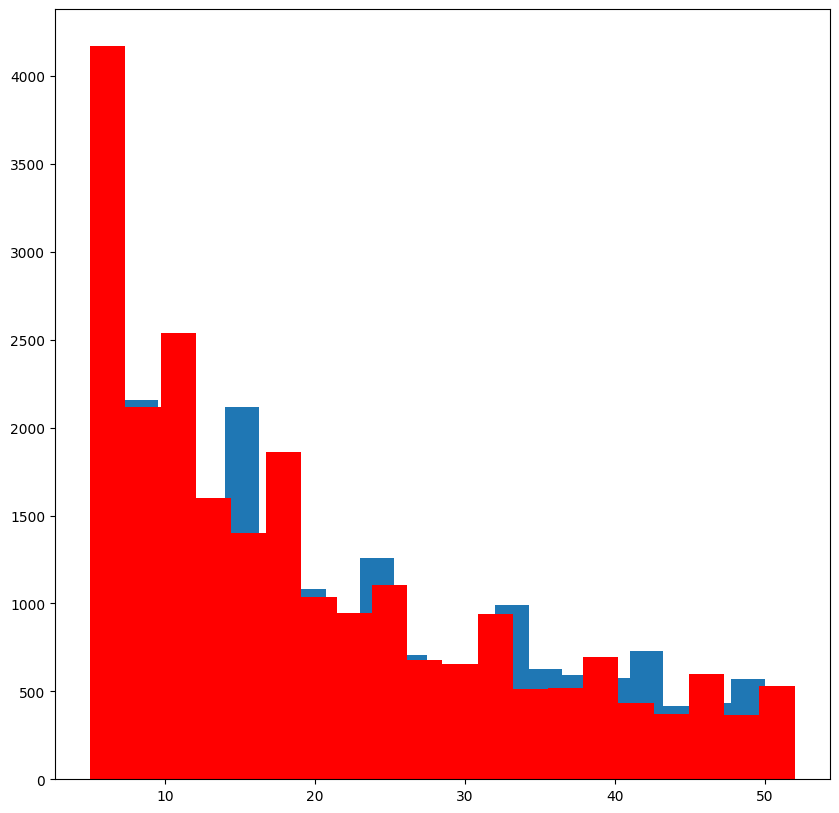

In [16]:
plt.figure(figsize=(10, 10))
np.arange
plt.hist(rounds30,  bins=20)
plt.hist(rounds40, color='r', bins=20)

plt.show()

так как величина выборки довольно большая, тестируем на нормальность с помощью Колмогорова-Смирнова:

In [17]:
sts.kstest(rounds30,"norm")


KstestResult(statistic=0.9999997133484281, pvalue=0.0)

Совпадает с картиной на гистограмме, распределение у нас ненормальное(похоже на логарифмическое)

In [18]:
# sts.kstest(rounds30,"lognorm",args=(50, len(rounds30)))
# sts.lognorm.cdf()



Видим, что распределение ненормальное, поэтому используем криттерий Манна-Уитни

In [19]:
sts.mannwhitneyu(rounds30, rounds40, alternative='two-sided')

MannwhitneyuResult(statistic=267544220.5, pvalue=0.05081084154695444)

Делаем вывод, что обе группы игроков играли примерно одинаковое количество раундов(нет статзначимости между выборками, так как pvalue > alpha=0.05)

#### Теперь посмотрим метрики конверсий.
**Для retention_1** :

In [20]:
m1 = group30['retention_1'].sum()
n1 = len(group30)
m2 = group40['retention_1'].sum()
n2 = len(group40)

n1,m1,n2,m2


(44700, 20034, 45489, 20119)

In [21]:
ret1_gr30 = m1/n1
ret1_gr40 = m2/n2

ret1_gr30,ret1_gr40

(0.4481879194630872, 0.44228274967574577)

In [22]:
score_1,p_val_1 = props.proportions_ztest(np.array([m1,m2]),np.array([n1,n2]))


print(f"P-value гипотезы, что retention1 одинаковы равен {p_val_1:.4f}")

P-value гипотезы, что retention1 одинаковы равен 0.0744


In [31]:
group30['retention_1']

0        0
1        1
6        0
11       0
13       1
        ..
90179    1
90180    0
90182    1
90183    0
90186    1
Name: retention_1, Length: 44700, dtype: int64

In [52]:
chitest = sts.chisquare(['16', '18', '16', '14', '12', '12', '1'], ['16', '16','1', '16', '16', '16', '8'])
print(chitest)

UFuncTypeError: ufunc 'add' did not contain a loop with signature matching types (dtype('<U2'), dtype('<U2')) -> None

P-value > alpha 5%, значит по retention1 мы не видим статзначимых различий.

найдем величину эффекта по формуле: $$h = \phi_{1} -\phi_{2}$$ ,где 
$\phi_{i} = 2*\arcsin(\sqrt{P_i})$


In [23]:
h= 2*np.arcsin(np.sqrt(ret1_gr30)) - 2*np.arcsin(np.sqrt(ret1_gr40))
h

0.011881898259223478

In [24]:
smp.zt_ind_solve_power(effect_size=h,nobs1=len(group30), ratio =len(group40)/len(group30),alpha = 0.05 )

0.43028578572010956

Мощность меньше 40%, значит результаты теста нужно смотреть с оговоркой о недостаточном числе пользователей, если величина эффекта порядка 0.1% для нас является ожидаемой.

**Для retention_7** :

In [25]:
m1 = group30['retention_7'].sum()
n1 = len(group30)
m2 = group40['retention_7'].sum()
n2 = len(group40)

n1,m1,n2,m2

(44700, 8502, 45489, 8279)

In [26]:
ret7_gr30 = m1/n1
ret7_gr40 = m2/n2

ret7_gr30,ret7_gr40

(0.19020134228187918, 0.18200004396667327)

In [27]:
h= 2*np.arcsin(np.sqrt(ret7_gr30)) - 2*np.arcsin(np.sqrt(ret7_gr40))
h

0.021074001016365917

In [28]:
smp.zt_ind_solve_power(effect_size=h,nobs1=len(group30), ratio =len(group40)/len(group30),alpha = 0.05 )

0.8857696023365191

Мощность достаточно велика, поэтому можно поискать статзначимость.
Проверим по хи-квадрат

In [29]:
score,p_val = props.proportions_ztest(np.array([m1,m2]),np.array([n1,n2]))

print(f"P-value гипотезы, что retention7 одинаковы равен {p_val:.4f}")

P-value гипотезы, что retention7 одинаковы равен 0.0016


P-value меньше альфа 5%, следовательно, есть статзначимые различия

In [30]:
sts.chisquare(group30['retention_7'],group40['retention_7'])


ValueError: shapes (44700,) and (45489,) could not be broadcast together